In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

# Set seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)
pd.set_option("display.max_columns", None)

In [2]:
# Technical indicators
trend_indicators = ["DMN_5", "DMN_10", "ADX_5", "ADX_10", "DMP_5"]
oscillators =["MACD_8_21_5", "STOCHd_7_3_3", "RSI_7"]
moving_averages = ["MA_20", "KAMA_3_2_10", "EMA_15", "MA_10"]
volatility_indicators = ["Bollinger_Lower", "Bollinger_Upper"]
other_indicators = []
technical_indicators = (
    trend_indicators + oscillators + moving_averages + volatility_indicators + other_indicators
)

# LOB specific indicators
mid_price_indicators = ["std_mid_price", "weighted_mid_price_variation", "mean_mid_price_variation"]
bid_ask_prices_indicators = ["std_spread", "mean_spread"]
volume_indicators = ["total_bid_volume", "total_ask_volume", "std_best_bid_size", "std_best_ask_size"]
orders_indicators = ["mean_order_book_imbalance", "order_book_imbalance_5s", "order_flow_5s", "last_order_book_imbalance", "total_net_order_flow"]
lob_indicators = mid_price_indicators + bid_ask_prices_indicators + volume_indicators + orders_indicators

time_indicators = ['time_since_open']

# Feature list
features =  lob_indicators + time_indicators

In [3]:
# Parameters
sampling_rate = "2s"
prediction_column = "mean_mid_price_variation_class"
batch_size = 32
look_back = 16

In [4]:
raw_data = pd.read_parquet("all_data.parquet")

start_date = "2024-11-01"
end_date = "2024-11-15"

all_data = raw_data.loc[start_date:end_date]

all_data.head()

,mid_price_first,mid_price_last,mid_price_high,mid_price_low,mid_price_mean,std_mid_price,weighted_mid_price_first,weighted_mid_price_last,weighted_mid_price_mean,last_spread,mean_spread,std_spread,last_best_bid_price,mean_best_bid_price,last_best_ask_price,mean_best_ask_price,last_best_bid_size,mean_best_bid_size,std_best_bid_size,last_best_ask_size,mean_best_ask_size,std_best_ask_size,mean_second_ask_price,mean_second_bid_price,mid_price_variation,mid_price_variation_class,mean_mid_price_variation,mean_mid_price_variation_class,next_5_mean_mid_price_variation_class,weighted_mid_price_variation,weighted_mid_price_variation_class,total_bid_volume,total_ask_volume,mean_order_book_imbalance,last_order_book_imbalance,total_net_order_flow,num_added_orders,num_canceled_orders,num_traded_orders,order_book_imbalance_5s,order_flow_5s,bid_volume_variation,ask_volume_variation,bid_price_variation,ask_price_variation,trade_open,trade_close,trade_high,trade_low,ADX_5,ADX_7,ADX_10,DMP_5,DMP_10,DMN_5,DMN_10,AROONU_7,AROOND_7,OLL3,OLL5,OLL10,OLL15,OHH3,OHH5,STOCHk_7_3_3,STOCHd_7_3_3,MACD_8_21_5,RSI_7,AO_5_10,EMA_15,HMA_10,KAMA_3_2_10,MA_10,MA_20,rmCO(3),rmCO(4),rmCO(5),rmCO(6),Bollinger_Upper,Bollinger_Lower,U_minus_L,MA20dSTD,CO,C1O1,C2O2,C3O3,range,OH1,time_since_open,is_monday,is_tuesday,is_wednesday,is_thursday,is_friday
ts_recv,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-01 09:30:56-04:00,221.270,221.480,221.490,221.270,221.364828,0.065752,221.264000,221.479194,221.366193,0.04,0.040996,0.016342,221.46,221.344330,221.50,221.385326,250.0,199.972826,265.497897,271.0,138.467391,79.698131,221.395652,221.323986,0.000949,2.0,0.000429,1,0,0.000973,1,4046.0,-855.0,0.180239,-0.040307,-21,248.0,214.0,90,0.153203,62.8,150.0,121.0,0.0,0.0,221.31,221.48,221.480,221.275,63.622686,52.513422,48.673901,7.058336,16.423061,32.415299,24.022609,0.000000,85.714286,0.070,0.070,0.070,0.070,0.220,0.500,48.695652,25.982026,-0.057337,29.598239,-0.13850,221.501753,221.517636,221.418944,221.596028,221.546464,0.023333,-0.03125,-0.047,-0.045833,221.875744,221.217185,0.658559,0.149676,0.210,-0.185,0.045,-0.195,0.220,0.025,56.0,0,0,0,0,1
2024-11-01 09:30:58-04:00,221.480,221.395,221.480,221.395,221.447152,0.024410,221.476103,221.382350,221.446355,0.03,0.037616,0.010096,221.38,221.428344,221.41,221.465960,17.0,124.586093,68.131865,200.0,161.072848,127.035904,221.477715,221.416424,-0.000384,0.0,-0.000148,0,0,-0.000423,0,-44.0,2789.0,-0.129525,-0.843318,-183,141.0,132.0,29,0.127776,21.0,-233.0,-71.0,0.0,0.0,221.46,221.41,221.460,221.410,63.745693,51.219048,45.685463,6.328729,15.603109,29.064588,22.823235,0.000000,71.428571,0.280,0.280,0.280,0.280,0.010,0.115,34.210526,31.158428,-0.044093,42.925839,-0.15375,221.494928,221.490568,221.421115,221.566291,221.561209,-0.020000,-0.00375,-0.042,-0.053333,221.841297,221.281120,0.560177,0.143083,-0.085,0.210,-0.185,0.045,0.085,0.220,58.0,0,0,0,0,1
2024-11-01 09:31:00-04:00,221.400,221.240,221.400,221.210,221.297895,0.054748,221.382353,221.242075,221.292181,0.04,0.044880,0.015096,221.22,221.275455,221.26,221.320335,250.0,124.739234,212.621711,203.0,147.367225,104.094788,221.332273,221.261077,-0.000723,0.0,-0.000461,0,0,-0.000634,0,2890.0,3709.0,-0.084526,0.103753,47,365.0,346.0,125,0.084485,30.2,233.0,3.0,0.0,0.0,221.38,221.26,221.385,221.200,67.010929,52.800293,44.937488,4.910472,13.881752,44.371354,31.047163,14.285714,57.142857,0.190,0.200,0.200,0.200,0.090,0.090,7.017544,29.974574,-0.046890,30.651973,-0.14700,221.470299,221.441768,221.412795,221.523023,221.554555,-0.011667,-0.05500,-0.035,-0.061667,221.852459,221.256650,0.595809,0.159168,-0.160,-0.085,0.210,-0.185,0.190,0.000,60.0,0,0,0,0,1
2024-11-01 09:31:02-04:00,221.240,221.165,221.270,221.035,221.155603,0.070773,221.242833,221.179933,221.159798,0.03,0.037525,0.013919,221.15,221.136840,221.18,221.174365,447.0,211.879442,244.032471,1.0,87.388325,77.428798,221.187297,221.124061,-0.000339,0.0,-0.000381,0,1,-0.000284,0,5975.

In [5]:
all_data[prediction_column].value_counts()

mean_mid_price_variation_class
0    56117
1    48062
Name: count, dtype: int64

In [6]:
# Data splitting
train_size = int(len(all_data) * 0.5)
val_size = int(len(all_data) * 0.1)
test_size = len(all_data) - train_size - val_size

train_df = all_data.iloc[:train_size, :]
val_df = all_data.iloc[train_size : train_size + val_size, :]
test_df = all_data.iloc[train_size + val_size :, :]

In [7]:
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler

class ScaledTimeSeriesDataset(Dataset):
    def __init__(self, data, target, features, look_back):
        self.data = data[features].values
        self.targets = data[target].values.astype(int)
        self.features = features
        self.look_back = look_back

    def __len__(self):
        return len(self.data) - self.look_back

    def __getitem__(self, idx):
        sequence = self.data[idx : idx + self.look_back]
        target = self.targets[idx + self.look_back]

        # Apply scaling for each training example
        scaler = MinMaxScaler(feature_range=(0, 1))
        sequence = scaler.fit_transform(sequence)

        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(
            target, dtype=torch.long
        )


In [8]:
# Create datasets
train_dataset = ScaledTimeSeriesDataset(train_df, prediction_column, features, look_back)
val_dataset = ScaledTimeSeriesDataset(val_df, prediction_column, features, look_back)
test_dataset = ScaledTimeSeriesDataset(test_df, prediction_column, features, look_back)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# Define the PyTorch model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size2, 32)
        self.dropout3 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = x.permute(0, 2, 1)  # Reshape for BatchNorm
        x = self.bn1(x)
        x = x.permute(0, 2, 1)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = x.permute(0, 2, 1)
        x = self.bn2(x)
        x = x.permute(0, 2, 1)
        x = self.dropout2(x)
        x = x[:, -1, :]  # Take the last time step
        x = self.fc1(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        return x
    

class LSTMModelWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(LSTMModelWithAttention, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(0.2)
        
        # Attention layer
        self.attention = nn.Linear(hidden_size1, 1)  # Computes attention scores
        
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size2, 32)
        self.dropout3 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        # First LSTM layer
        x, _ = self.lstm1(x)
        x = x.permute(0, 2, 1) 
        x = self.bn1(x)
        x = x.permute(0, 2, 1)
        x = self.dropout1(x)
        
        # Attention mechanism
        attention_scores = self.attention(x)  # Compute attention scores (batch_size, seq_len, 1)
        attention_scores = nn.functional.softmax(attention_scores, dim=1)  # Apply softmax to get attention weights
        x = x * attention_scores  # Apply attention weights to the sequence
        x = x.sum(dim=1)  # Sum over the sequence dimension to get a weighted representation
        
        # Second LSTM layer
        x = x.unsqueeze(1)  # Add sequence dimension back for LSTM input
        x, _ = self.lstm2(x)
        x = x.permute(0, 2, 1)
        x = self.bn2(x)
        x = x.permute(0, 2, 1)
        x = self.dropout2(x)
        x = x[:, -1, :]  # Take the last time step
        x = self.fc1(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

In [10]:
import torch.optim as optim

# Initialize model, loss, and optimizer
input_size = len(features)
hidden_size1 = 128
hidden_size2 = 64
num_classes = len(np.unique(all_data[prediction_column]))

model = LSTMModel(input_size, hidden_size1, hidden_size2, num_classes)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [11]:
# Training loop
num_epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model is on device: {next(model.parameters()).device}")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        train_loss += loss.item()
        
        # Compute training accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += batch_y.size(0)
        correct_train += (predicted_train == batch_y).sum().item()

    train_loss /= len(train_loader)
    train_acc = correct_train / total_train

    # Validation
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            val_loss += criterion(outputs, batch_y).item()
            _, predicted_val = torch.max(outputs.data, 1)
            total_val += batch_y.size(0)
            correct_val += (predicted_val == batch_y).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct_val / total_val

    print(
        f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )


Model is on device: cpu
Epoch 1/1, Train Loss: 0.6858, Train Acc: 0.5536, Val Loss: 0.6778, Val Acc: 0.5673


Accuracy: 0.5675
              precision    recall  f1-score   support

           0       0.60      0.60      0.60     22599
           1       0.53      0.53      0.53     19058

    accuracy                           0.57     41657
   macro avg       0.56      0.56      0.56     41657
weighted avg       0.57      0.57      0.57     41657



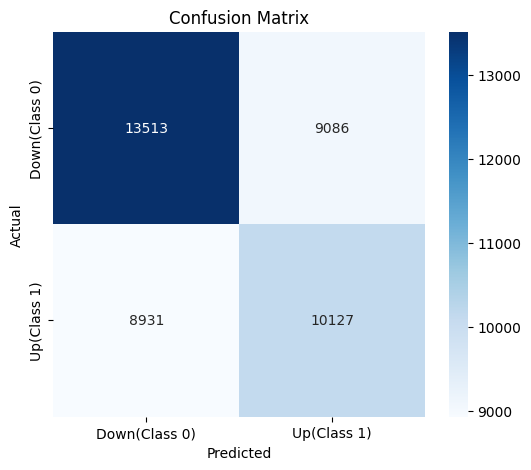

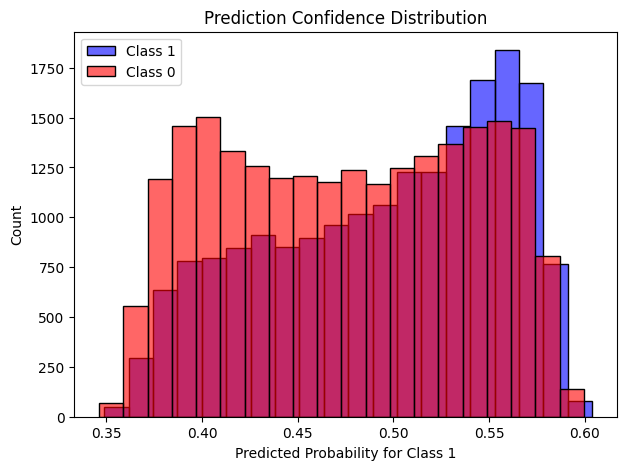

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Testing
model.eval()
all_predictions = []
true_labels = []
all_probs = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        
        # Get predicted class and probabilities
        probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
        _, predicted = torch.max(outputs.data, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        true_labels.extend(batch_y.cpu().numpy())
        all_probs.extend(probs.cpu().numpy()[:, 1])  # Store probabilities for class 1

# Convert to numpy arrays
true_labels = np.array(true_labels)
all_predictions = np.array(all_predictions)
all_probs = np.array(all_probs)

print(f"Accuracy: {accuracy_score(true_labels, all_predictions):.4f}")
print(classification_report(true_labels, all_predictions, zero_division=0))

conf_matrix = confusion_matrix(true_labels, all_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Down(Class 0)", "Up(Class 1)"], yticklabels=["Down(Class 0)", "Up(Class 1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(7, 5))
sns.histplot(all_probs[true_labels == 1], color="blue", label="Class 1", bins=20, alpha=0.6)
sns.histplot(all_probs[true_labels == 0], color="red", label="Class 0", bins=20, alpha=0.6)
plt.xlabel("Predicted Probability for Class 1")
plt.ylabel("Count")
plt.title("Prediction Confidence Distribution")
plt.legend()
plt.show()


Backtest Metrics for LSTM Strategy:
Final Capital: 1146.24
Annualized Return: 97058.70%
Annualized Volatility: 19.72%


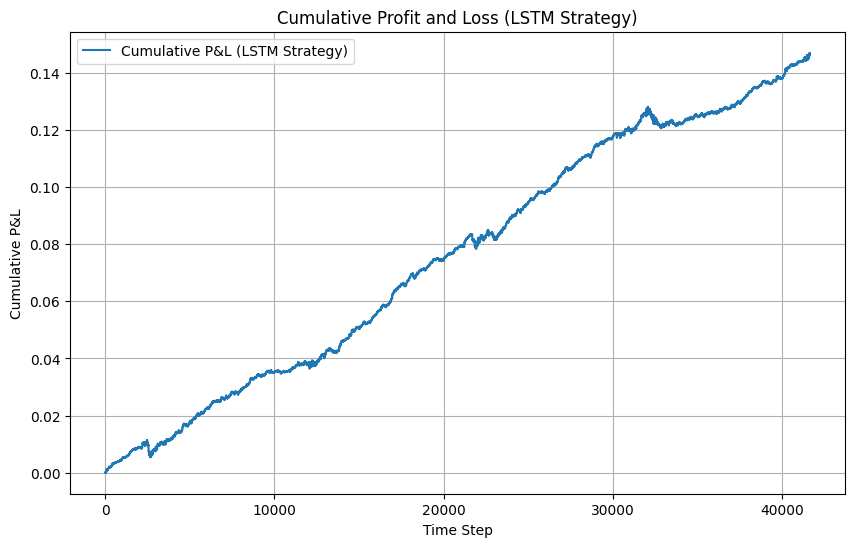

In [13]:
from finance_utils import plot_backtest_results, backtest_strategy

# Extract true percentage changes from the dataset
true_percentage_changes = test_df["mid_price_variation"].iloc[look_back:].values
timestamps = test_df.index[look_back:]

lstm_results = backtest_strategy(
    all_predictions, true_percentage_changes, timestamps, initial_capital=1000
)
plot_backtest_results(lstm_results, "LSTM Strategy")

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

logistic_train_df = pd.concat([train_df, val_df], axis=0)

# Shift y_train and y_test one step backward
y_train = logistic_train_df[prediction_column].shift(-1).dropna().astype(int)
y_test = test_df[prediction_column].shift(-1).dropna().astype(int)

# Drop the last row of X_train and X_test to align with y_train and y_test
X_train = logistic_train_df[features].iloc[:-1].values
X_test = test_df[features].iloc[:-1].values

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the logistic regression model
log_reg = LogisticRegression(solver='saga', max_iter=1000, random_state=0)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0, solver='saga')

Test Accuracy (Logistic Regression): 0.5620
              precision    recall  f1-score   support

           0       0.57      0.82      0.67     22608
           1       0.55      0.26      0.35     19064

    accuracy                           0.56     41672
   macro avg       0.56      0.54      0.51     41672
weighted avg       0.56      0.56      0.52     41672



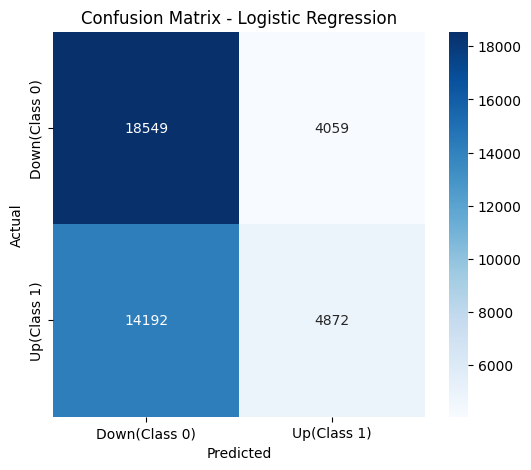

In [29]:
# Evaluate on the test set
test_predictions = log_reg.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy (Logistic Regression): {test_accuracy:.4f}")
print(classification_report(y_test, test_predictions, zero_division=0))

# Confusion Matrix for the test set
conf_matrix_log_reg = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_log_reg, annot=True, fmt="d", cmap="Blues", xticklabels=["Down(Class 0)", "Up(Class 1)"], yticklabels=["Down(Class 0)", "Up(Class 1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


Backtest Metrics for Logistic Regression Strategy:
Final Capital: 1071.61
Annualized Return: 3164.43%
Annualized Volatility: 10.04%


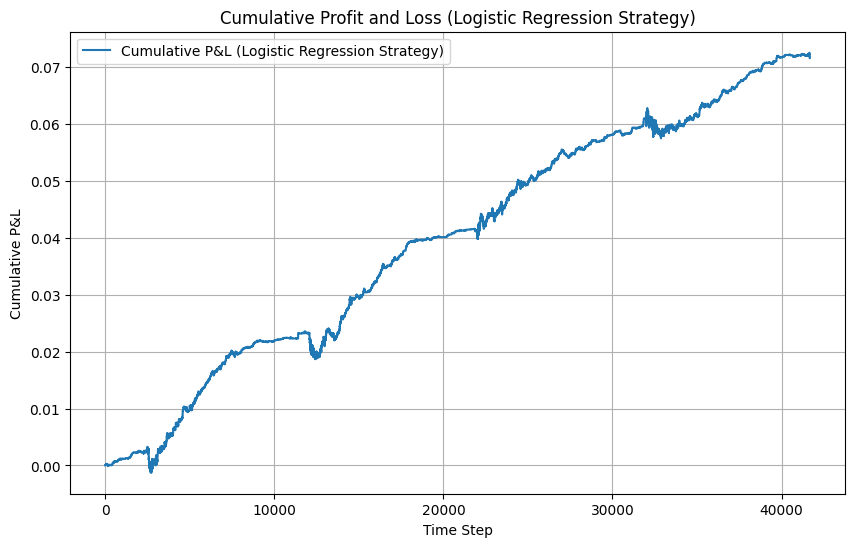

In [32]:
# Backtest the logistic regression strategy
true_percentage_changes_logistic = test_df["mid_price_variation"].iloc[1:].values
timestamps_logistic = test_df.index[1:]

log_reg_results = backtest_strategy(
    test_predictions, true_percentage_changes_logistic, timestamps_logistic, initial_capital=1000
)
plot_backtest_results(log_reg_results, "Logistic Regression Strategy")

Random Prediction Accuracy: 0.5009
              precision    recall  f1-score   support

           0       0.54      0.50      0.52     22599
           1       0.46      0.50      0.48     19058

    accuracy                           0.50     41657
   macro avg       0.50      0.50      0.50     41657
weighted avg       0.50      0.50      0.50     41657



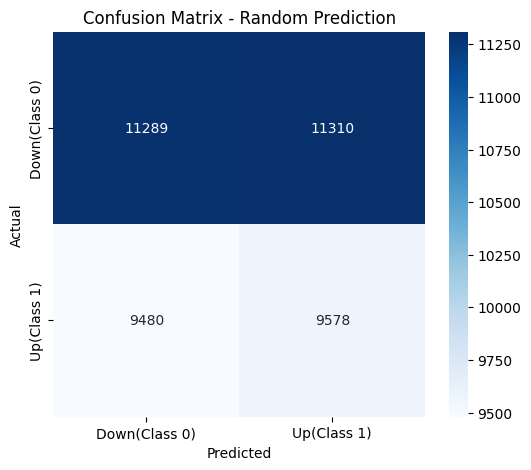

In [14]:
# Baseline strategy: Random prediction
random_predictions = np.random.randint(0, 2, size=len(true_labels))
print(f"Random Prediction Accuracy: {accuracy_score(true_labels, random_predictions):.4f}")
print(classification_report(true_labels, random_predictions, zero_division=0))

conf_matrix_random = confusion_matrix(true_labels, random_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_random, annot=True, fmt="d", cmap="Blues", xticklabels=["Down(Class 0)", "Up(Class 1)"], yticklabels=["Down(Class 0)", "Up(Class 1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Prediction")
plt.show()


Backtest Metrics for Random Strategy:
Final Capital: 1001.22
Annualized Return: 6.35%
Annualized Volatility: 15.17%


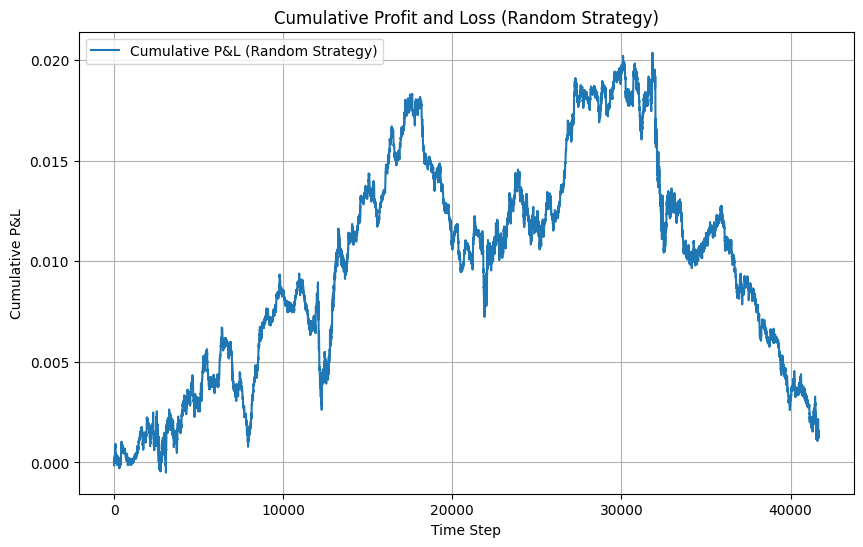

In [15]:
random_results = backtest_strategy(
    random_predictions, true_percentage_changes, timestamps, initial_capital=1000
)
plot_backtest_results(random_results, "Random Strategy")

Most Common Class Prediction Accuracy: 0.5425
              precision    recall  f1-score   support

           0       0.54      1.00      0.70     22599
           1       0.00      0.00      0.00     19058

    accuracy                           0.54     41657
   macro avg       0.27      0.50      0.35     41657
weighted avg       0.29      0.54      0.38     41657



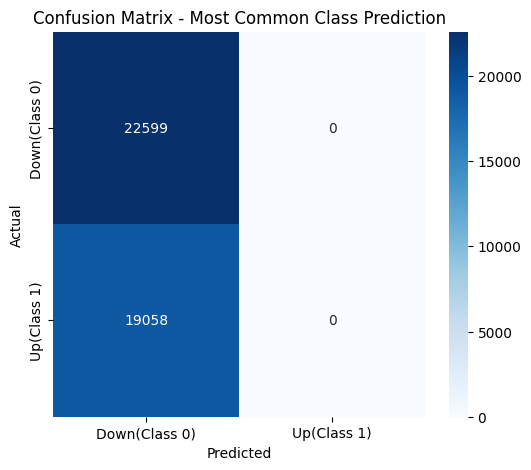

In [19]:
train_labels = []
for _, batch_y in train_loader:
    train_labels.extend(batch_y.cpu().numpy())
train_labels = np.array(train_labels)
most_common_class = np.bincount(train_labels).argmax()
most_common_predictions = np.full_like(true_labels, most_common_class)
print(f"Most Common Class Prediction Accuracy: {accuracy_score(true_labels, most_common_predictions):.4f}")
print(classification_report(true_labels, most_common_predictions, zero_division=0))

conf_matrix_most_common = confusion_matrix(true_labels, most_common_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_most_common, annot=True, fmt="d", cmap="Blues", xticklabels=["Down(Class 0)", "Up(Class 1)"], yticklabels=["Down(Class 0)", "Up(Class 1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Most Common Class Prediction")
plt.show()


Backtest Metrics for Most Common Class Strategy:
Final Capital: 1000.00
Annualized Return: 0.00%
Annualized Volatility: 0.00%


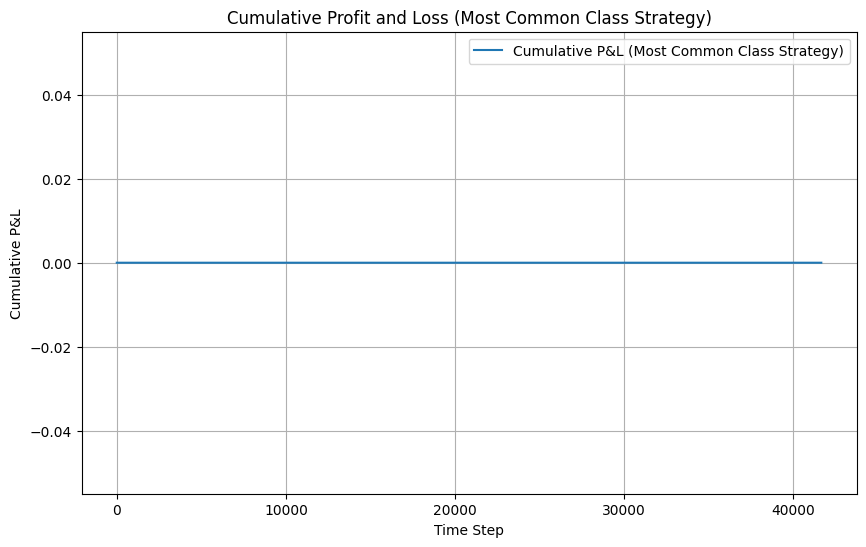

In [20]:
most_common_results = backtest_strategy(
    most_common_predictions, true_percentage_changes, timestamps, initial_capital=1000
)
plot_backtest_results(most_common_results, "Most Common Class Strategy")